# Separación de componentes con redes neuronals 
En este lab la idea es que separéis una señal en las distintas componentes que la consituyen. El caso que estudiaremos es el cielo en el rango de las microondas. La señal que nos llega es una mezcla de fondo cósmico de microondas (CMB), radiación debida al polvo térmico interestelar, y la radiación sincrotrón debida a partículas atravesando el campo magnético de nuestra Galaxia. Cuanto mejor las caractericemos, mejor las podremos estudiar, tanto para análisis cosmológicos (CMB) o para el estudio de nuestra Galaxia (sincrotrón y polvo). Así la señal que recibimos es a cada frecuencia $\nu$ es: 
\begin{equation}
S_{\nu}=S_{cmb}+S_{synch}+S_{dust}+noise
\end{equation}

Conocemos el modelo de como se comportan frecuencialmente estas componentes por separado y se puede caracterizar por 4 parámteros: Amplitud del Cmb ($A_{cmb}$), Amplitud del syncrotron e índice espectral del sincrotrón ($A_{s}$) y ($\beta_s$) y el polvo térmico con su amplitud a 353GHz $A_{d}$. 

Os vamos a dar tres data sets. Cada uno de ellos tendrá la señal (en K) con todas las componentes mezcladas más una contribución de ruido (debida a la sensibilidad del detector, cantidad de tiempo observado, etc.) y los 4 parámetros de las componentes: $A_{cmb}$, $A_{d}$ y $A_s$ y $\beta_s$ (detalles en la presentación):
* PLANCK:  9 frecuencias del satélite PLANCK de la ESA (30, 44, 70, 100, 143, 217, 353, 545, 857 GHZ).
* PLANCK + HASLAM : Añadimos un canal a muy baja frecuencia (0.408 GHz).

Los data sets los encontraréis en: SET+'_Signal_dataset.txt' y SET+'_Signal_labels.txt'

Trabajaremos con `healpy`, la parte de cargar mapas y visualizarlos está en este notebook. Podéis instalarlo con `pip install healpy`


# Ejercicio 1
   Buscaremos el mejor modelo para cada uno de los datasets y lo validaremos con uns simulación de mapas realistas
   *   **1.1.** Encuentra con una red neuronal un bueno modelo que relacione los inputs con los parámetros de las componentes para cada uno de los data sets.   
   *   **1.2.** Evalúa con una simulación independiente como de buenos son tus resultados. 
   *   **1.3.** Comenta qué parametros mejoran cuando añadimos una frecuencia más (más baja) y porqué. 

**(7 puntos)**

In [154]:
!pip install healpy

In [0]:
# Packages needed
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
import healpy as hp
cmap='coolwarm'
import keras

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

In [0]:
# Data sets characteristics
def DataSet(FLAG):
    if FLAG=='PLANCK':
        freq=[30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13.6, 100]
    if FLAG=='PLANCK+HASLAM':
        freq=[0.408,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    if FLAG=='PLANCK+HASLAM+QUIJOTE':
        freq=[0.408,11.,13.,17.,19.,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,10,10,10,10, 2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    return freq,sigma

In [158]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Read data set
path = "/content/drive/My Drive/DL-fisica/1 CMB/"
SET='PLANCK'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_PLANCK = StandardScaler().fit(Signal)
Signal = scaler_PLANCK.transform(Signal)

In [339]:
# 1.1 Start obtaining your models with a NN
model_PLANCK = models.Sequential()
model_PLANCK.add(layers.Dense(15,activation="sigmoid",input_shape = (Signal.shape[1],)))
#model_PLANCK.add(layers.Dropout(0.2))
model_PLANCK.add(layers.Dense(5,activation="sigmoid"))
#model_PLANCK.add(layers.Dropout(0.2))
model_PLANCK.add(layers.Dense(Labels.shape[1]))

model_PLANCK.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 15)                150       
_________________________________________________________________
dense_140 (Dense)            (None, 5)                 80        
_________________________________________________________________
dense_141 (Dense)            (None, 4)                 24        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


In [225]:
2**9

512

In [340]:
callback_es = callbacks.EarlyStopping(patience = 200)

model_PLANCK.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK = model_PLANCK.fit(Signal,Labels,batch_size = 2**6,epochs = 1000,validation_split = 0.15,callbacks=[callback_es])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 2s 20us/step - loss: 33279294.0168 - val_loss: 33669040.1184
Epoch 2/1000
85000/85000 [==============================] - 2s 19us/step - loss: 32859567.0406 - val_loss: 33210605.0219
Epoch 3/1000
85000/85000 [==============================] - 2s 19us/step - loss: 32408136.1992 - val_loss: 32757818.5312
Epoch 4/1000
85000/85000 [==============================] - 2s 19us/step - loss: 31963171.8935 - val_loss: 32312173.1627
Epoch 5/1000
85000/85000 [==============================] - 2s 19us/step - loss: 31526053.0989 - val_loss: 31874952.1483
Epoch 6/1000
85000/85000 [==============================] - 2s 19us/step - loss: 31097794.5199 - val_loss: 31446955.9861
Epoch 7/1000
85000/85000 [==============================] - 2s 19us/step - loss: 30678351.3815 - val_loss: 31027380.1728
Epoch 8/1000
85000/85000 [==============================] - 2s 19us/step - loss: 30267529.6883 - val_lo

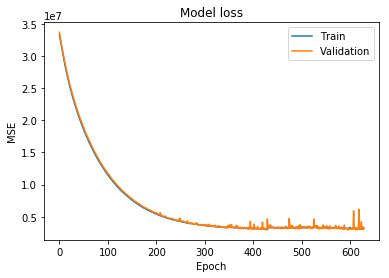

In [341]:
plt.plot(history_PLANCK.history['loss'])
plt.plot(history_PLANCK.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK.save(path+'PLANCK_model.h5')

In [0]:
# Read data set
path = "/content/drive/My Drive/DL-fisica/1 CMB/"
SET='PLANCK+HASLAM'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_PLANCK_HASLAM = StandardScaler().fit(Signal)
Signal = scaler_PLANCK_HASLAM.transform(Signal)

In [19]:
# 1.1 Start obtaining your models with a NN
model_PLANCK_HASLAM = models.Sequential()
model_PLANCK_HASLAM.add(layers.Dense(2**8,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**7,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**6,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**5,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(Labels.shape[1]))

model_PLANCK_HASLAM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               2816      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [20]:
callback_es = callbacks.EarlyStopping(patience = 10)

model_PLANCK_HASLAM.compile(optimizer = optimizers.Adam(lr = 1000),loss="mse")
history_PLANCK_HASLAM = model_PLANCK_HASLAM.fit(Signal,Labels,batch_size = 2**6,epochs = 1000,validation_split = 0.2,callbacks=[callback_es])

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 4s 50us/step - loss: 80417424348295472.0000 - val_loss: 77609360010458752.0000
Epoch 2/1000
80000/80000 [==============================] - 4s 48us/step - loss: 75184549997738512.0000 - val_loss: 72533768101015696.0000
Epoch 3/1000
80000/80000 [==============================] - 4s 48us/step - loss: 70245410003307248.0000 - val_loss: 67729603494303240.0000
Epoch 4/1000
80000/80000 [==============================] - 4s 48us/step - loss: 65579938483953200.0000 - val_loss: 63190626832918928.0000
Epoch 5/1000
80000/80000 [==============================] - 4s 48us/step - loss: 61192875032294776.0000 - val_loss: 58896086710930216.0000
Epoch 6/1000
80000/80000 [==============================] - 4s 48us/step - loss: 57025154740963296.0000 - val_loss: 54846323461545632.0000
Epoch 7/1000
80000/80000 [==============================] - 4s 48us/step - loss: 53122358592914688.0000 - val_loss: 

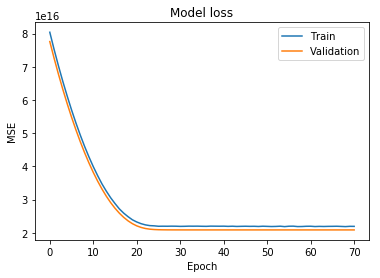

In [21]:
plt.plot(history_PLANCK_HASLAM.history['loss'])
plt.plot(history_PLANCK_HASLAM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK_HASLAM.save(path+'PLANCK_HASLAM_model.h5')

# Ejercicio 1.2 
Con una simulación realista (Datos/Data+SET+.fits) donde sabemos cada una de las componentes, comprueba tus resultados y comenta qué efecto tiene añadir frecuencias bajas a la estimación de tus parámetros. Visualizad los mapas que obtendríais con la red y los de verdad (Datos/Params+SET+.fits) y evaluad las diferencias. 

**(3 puntos)**

In [0]:
from keras.models import load_model

path = "/content/drive/My Drive/DL-fisica/1 CMB/"
model_PLANCK = load_model(path+'PLANCK_model.h5')
model_PLANCK_HASLAM = load_model(path+'PLANCK_HASLAM_model.h5')

In [0]:
# Cargamos con healpy los datos simulados 
SET='PLANCK'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

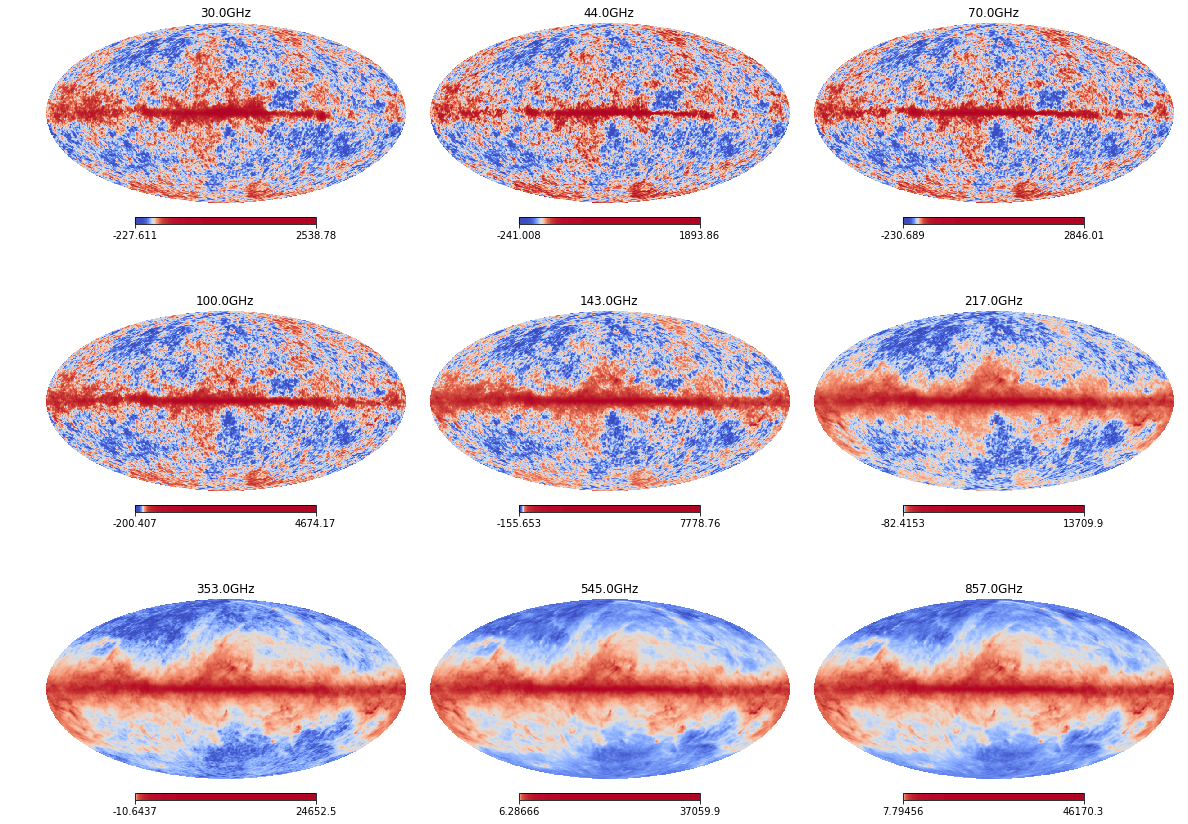

In [167]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK + HASLAM': n=4
if SET == 'PLANCK + HASLAM +QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
scaled_Data = scaler_PLANCK.transform(Datos.T)
Params_pred = model_PLANCK.predict(Datos.T)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Datos.T)
Datos_scaled = scaler.transform(Datos.T)
Params_pred = model_PLANCK.predict(Datos_scaled)

In [343]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse_score_PLANCK = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','A_s','B_s']



for i in range(len(params)):
  print('MSE for '+params[i]+' is: '+str(mse_score_PLANCK[i]))

MSE for A_cmb is: 7721.806464378763
MSE for A_d is: 775317.6877994189
MSE for A_s is: 0.012374377494211596
MSE for B_s is: 13328706.124353299


In [344]:
from scipy.stats import pearsonr
import pandas as pd

for i in range(4):
  print(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1])

0.8603166094593093
0.11925894576099133
-0.003003466231045451
0.5459702697729639


In [185]:
Params_pred[:,i]

array([9939.662, 9939.662, 9939.662, ..., 9939.662, 9939.662, 9939.662],
      dtype=float32)

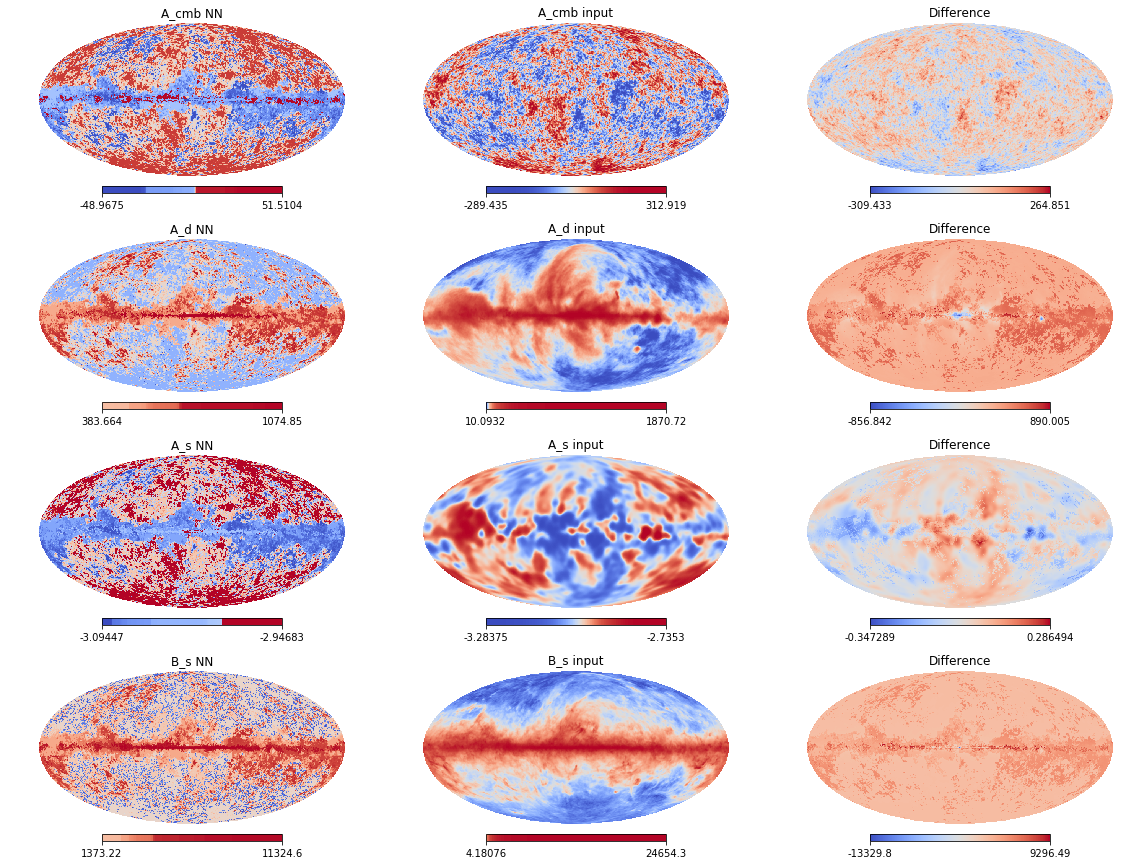

In [310]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','A_s','B_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

In [0]:
# 1.3  Comment what are the differences of both data sets


# Ejercicio 2. 
Para el caso PLANCK+HASLAM+QUIJOTE mandad vuestros resultados a la competición de Kaggle: https://www.kaggle.com/c/component-separation-with-nn. Podéis mandar tantos como queráis.

**(3 puntos)**